<a href="https://colab.research.google.com/github/chainzero/pytorch_models/blob/main/learning_rate_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

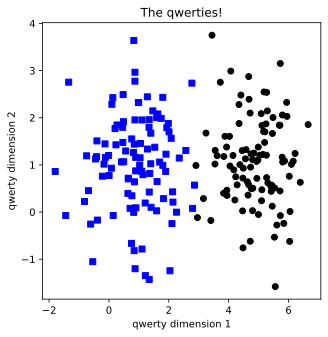

In [3]:
# parameters
nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

Functions to build and train the model


In [4]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
      #nn.Sigmoid(),    # final activation unit (not needed b/c we use BCEWithLogitsLoss)
        )

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [5]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  # final forward pass
  predictions = ANNmodel(data)

  # compute the predictions and report accuracy
  # NOTE: shouldn't it be predictions>.5??
  totalacc = 100*torch.mean(((predictions>0) == labels).float())

  return losses,predictions,totalacc

Test the new code by running it once


Final accuracy: 50%


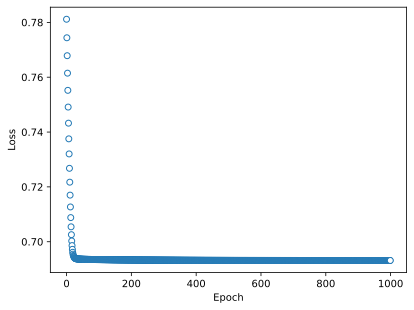

In [6]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

Now for the experiment

In [7]:
# the set of learning rates to test
learningrates = np.linspace(.001,.1,40)

# initialize results output
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# loop through learning rates
for i,lr in enumerate(learningrates):

  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()

<ipython-input-7-49ebd2e9162b>:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allLosses[i,:] = losses.detach()


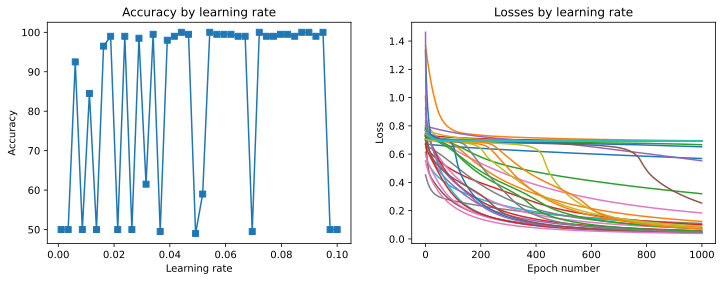

In [8]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [9]:
# proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.6750)

Run a meta-experiment to get more reliable results


In [ ]:
# run a "meta-experiment" by repeating the experiment N times
#  (different random weight initializations each time)
# note: this cell takes ~7 mins.

# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps,len(learningrates)))

# fewer epochs to reduce computation time
numepochs = 500

# now for the experiment
for expi in range(numExps):
  for i,lr in enumerate(learningrates):

    # create and run the model
    ANNclassify,lossfun,optimizer = createANNmodel(lr)
    losses,predictions,totalacc = trainTheModel(ANNclassify)

    # store the results
    accMeta[expi,i] = totalacc



# now plot the results, averaged over experiments
plt.plot(learningrates,np.mean(accMeta,axis=0),'s-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()